# Model Project - Dynamic Optimization With and Without Income Risk

**Team:** Kongerækken

**Members:** Frederik Degn Pedersen and Christian Brauer Johanssen

**Project description:** Throughout this project, we employ a two period model of consumer behavior. Initially, we perform analysis using `sympy` on a simple version of the model only featuring consumption goods and an initial cash endowment. Next, we expand the model to include income in the second period as well as a utility providing altruistic/inheritance motive. Finally, we expand the model further by introducing two different risk structures and compare consumer behavior acrossspecifications. 

Imports and set magics:

In [2]:
# importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import ipywidgets as widgets
import time
from scipy import optimize
from scipy import interpolate
import sympy as sm
from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local module
import modelproject

# Model Analysis - The Simple Case

To start, we consider a simple two period consumer problem without uncertainty, where the following definitions of **variables** and **parameters** apply:

* $m$ is the endowment (cash-on-hand). In this simplified version the consumer only get an endowment in period 1.
* $c$ is consumption
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$ are utility parameters (subjective discount factor and coefficient of risk aversion)
* Subscripts denotes periods

Assuming CRRA utility from consumption in both periods, the combined utility function, $U$, can be written as 

$$
\begin{align}
    U &= \max_{c_1,c_2}\frac{c_1^{1-\rho}}{1-\rho}+\beta\frac{c_2^{1-\rho}}{1-\rho} \\
    \text{s.t.} \\
    c_2 &= (1+r)(m_1-c_1) \\
    c_{1} &\in [0,m_{1}] \\
\end{align}
$$

where the constraint on consumption in period 2 results from the intertemporal budget constraint. Borrowing is not possible by the second constraint. 

## Analysis Using `sympy`
As this simple version of the model has a nice, closed form solution, we can use sympy to solve analytically for optimal consumption as follows: 
* First, we define all symbols
* Next, we define the objective function ($U$)
* Then we define the budget constraint and solve it for $c_2$
* Ultimately we substitute for $c_2$ in the objective function and differentiate with respect to $c_1$

In [3]:
# define symbols
m1 = sm.symbols('m_1')
c1 = sm.symbols('c_1')
c2 = sm.symbols('c_2')
r = sm.symbols('r')
beta = sm.symbols('beta')
rho = sm.symbols('rho')

# define objective
m2 = (1+r)*(m1-c1)
obj = c1**(1-rho)/(1-rho)+beta*(c2**(1-rho)/(1-rho))

# define constraint and solve for c2
cons = sm.Eq(c2,(1+r)*(m1-c1))
c2_from_cons = sm.solve(cons,c2)

# substitute for c2 and take first order conditions
obj_subs = obj.subs(c2,c2_from_cons[0])

dU_dc1 = sm.diff(obj_subs,c1)
dU_dc1

beta*(-r - 1)*(-c_1*r - c_1 + m_1*r + m_1)**(1 - rho)/(-c_1*r - c_1 + m_1*r + m_1) + c_1**(1 - rho)/c_1

Before we can solve for optimal consumption in period 1, we need to help `sympy` understand that the above expression is equal to 

$$
\begin{align}
    \frac{1}{c_1} &= \frac{\left(\beta(1+r)\right)^\frac{1}{\rho}}{(1+r)(m_1-c_1)}
\end{align}
$$

In [4]:
# help sympy collect terms
dU_dc1_simple = sm.Eq(1/c1,(beta*(1+r))**(1/rho)/((1+r)*(m1-c1)))
display(dU_dc1_simple)

Eq(1/c_1, (beta*(r + 1))**(1/rho)/((-c_1 + m_1)*(r + 1)))

In [5]:
# solve for optimal c1
c1_star_solve = sm.solve(dU_dc1_simple,c1)
c1_star = c1_star_solve[0]
c1_star

m_1*(r + 1)/(r + (beta*(r + 1))**(1/rho) + 1)

From the above expression it can easily be observed that period 1 consumption is increasing in $m_1$ (more cash, more consumption) and decreasing in $\beta$ (higher patience, lower period 1 consumption), whereas the effect from the interest rate is more convoluted. This is because we have counteracting income and substitution effects that does not cancel out due to the fact that we have not assumed log-utility.

Inserting the above expression for $c_1$ we can residually compute the optimal level of second period consumption:

In [6]:
# compute optimal c2
cons_subs = cons.subs(c1,c1_star)
c2_star_solve = sm.solve(cons_subs,c2)
c2_star = c2_star_solve[0]
c2_star

m_1*(beta*(r + 1))**(1/rho)*(r + 1)/(r + (beta*(r + 1))**(1/rho) + 1)

To be able to insert parameter values in the analytical solution, we turn the sympy functions into actual functions using sm.lambdify:

In [7]:
# lambdify functions for c1 and c2
c1_func = sm.lambdify((m1,r,beta,rho),c1_star)
c2_func = sm.lambdify((m1,r,beta,rho),c2_star)

## Numerical Solution Using an Algorithm 
Given some parameter values, it is also possible to solve numerically for optimal consumption in both periods. Particularly, we can set period 1 optimal consumption equal to zero to make it a root finding problem:
$$
\begin{align}
    0 &= \frac{1}{c_1} - \frac{\left(\beta(1+r)\right)^\frac{1}{\rho}}{(1+r)(m_1-c_1)}
\end{align}
$$

There are several algorithms that can solve such a problem. In the module, we define a function which uses the **bisection** method to find the root. This method is convenient in this particular setting, as we do not have to calculate derivatives. The way the algorithm works is that it compares function values over a grid, gradually closing in on the root. A necessary condition for the method to work is that the function values needs to have opposite values in the endpoints, as this ensures that a root exists between the two endpoints. 

Now, we can define parameter values and use both the analitycally derived functions and the numerical algorithm to find the solution:

In [8]:
# define parameter values
m1 = 1
r = 0.04
beta = 0.94
rho = 8

# solve analytically and numerically
c1_s, c2_s = modelproject.solve_for_consumption(m1,r,beta,rho)

print(f'analytical solution is: c1 = {c1_func(m1,r,beta,rho):.3f}, c2 = {c2_func(m1,r,beta,rho):.3f}')
print(f'numerical solution is: c1 = {c1_s:.3f}, c2 = {c2_s:.3f}\n')
print(f'analytical and numerical solution are equal with numerical precision: \nc1: {np.isclose(c1_func(m1,r,beta,rho),c1_s)} \nc2: {np.isclose(c2_func(m1,r,beta,rho),c2_s)}')

analytical solution is: c1 = 0.511, c2 = 0.509
numerical solution is: c1 = 0.511, c2 = 0.509

analytical and numerical solution are equal with numerical precision: 
c1: True 
c2: True


## Parameter Sensitivity

Before 

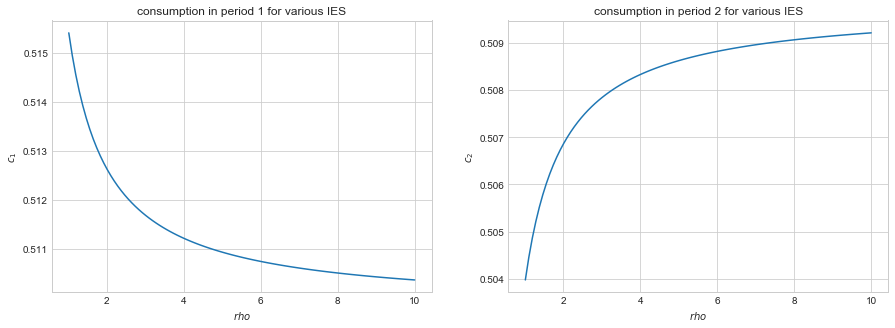

In [22]:
# inc. effect dominates subs. effect
rho_v = np.linspace(1.01,10,100) 
c1_l = np.empty(len(rho_v))
c2_l = np.empty(len(rho_v))
r = 0.04


for i, rh in enumerate(rho_v):
    c1_l[i],c2_l[i] = modelproject.solve_for_consumption(m1,r,beta,rh)
    
# plot consumption for rho values
fig = plt.figure(figsize=(15,5))
    
ax = fig.add_subplot(1,2,1)
ax.plot(rho_v,c1_l)
ax.set_xlabel('$rho$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption in period 1 for various IES');

ax = fig.add_subplot(1,2,2)
ax.plot(rho_v,c2_l)
ax.set_xlabel('$rho$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption in period 2 for various IES');

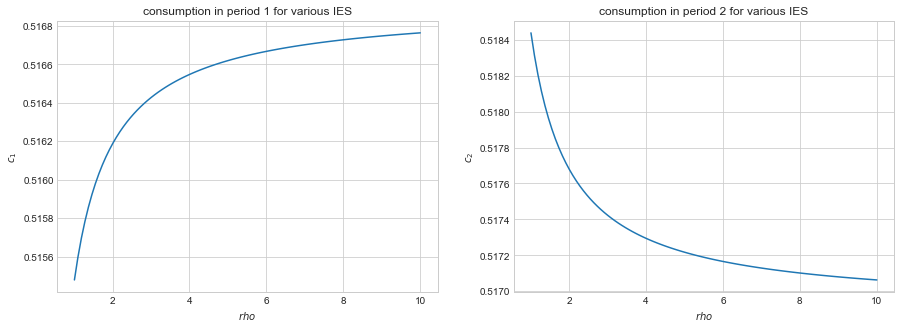

In [21]:
# subs. effect dominates inc. effect
r = 0.07

rho_v = np.linspace(1.01,10,100) 
c1_l = np.empty(len(rho_v))
c2_l = np.empty(len(rho_v))

for i, rh in enumerate(rho_v):
    c1_l[i],c2_l[i] = modelproject.solve_for_consumption(m1,r,beta,rh)
    
# plot consumption for rho values
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
ax.plot(rho_v,c1_l)
ax.set_xlabel('$rho$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption in period 1 for various IES');

ax = fig.add_subplot(1,2,2)
ax.plot(rho_v,c2_l)
ax.set_xlabel('$rho$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption in period 2 for various IES');



# Model Extension

Now we introduce income in the second period as well as letting the consumer obtain utility for leaving a bequest for its heirs. Define the following additional **variables** and **parameters**:

* $y_t$ is income in period $t$
* $\nu > 0 $, $\kappa > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= 1\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

First we define parameter values for all new **symbols**:

In [97]:
kappa = 0.5
nu = 0.1
Delta = 0.5 # for later use
r = 0.04
beta = 0.94
rho = 8

# The risk free case
To solve this more elaborate dynamic optimization problem, we use the dynamic programming approach covered in Lecture 11.

## Defining value functions and solution functions

To start, we define the **basic functions** and use them to build the **value functions**:

In [73]:
# basic functions
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

# value functions
def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,v2_interp):
    y2=1
    m2 = (1+r)*(m1-c1) + y2 
    v2 = v2_interp([m2])[0]

    # total value
    return utility(c1,rho) + beta*v2

Next, we set up the **solution functions**, in the spirit of backwards induction beginning by period 2.

In [74]:
def solve_period_2(rho,nu,kappa):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500) # vector of potential m2 values
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda c2: -v2(c2,m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,v2_interp,v1):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda c1: -v1(c1,m1,rho,beta,r,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1*1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return m1_vec,v1_vec,c1_vec


## Joint Solve Function and Plot of Consumption

In [75]:
# joint solve function
def solve(rho,beta,r,nu,kappa,v1):
    
    # a. solve period 2
    m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator((m2_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
    
    # c. solve period 1
    m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,v2_interp,v1)
    
    return m1_vec,c1_vec,m2_vec,c2_vec

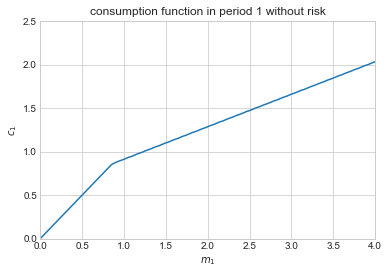

In [76]:
# plot risk free consumption
m1_vec,c1_vec,m2_vec,c2_vec = solve(rho,beta,r,nu,kappa,v1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1 without risk')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

From the figure, it can be observed that the consumer lives "hand to mouth" for $m_1$ lower than $\sim$ 0.8, whereafter the kink in the consumption function indicates that some of the cash increase is saved for period 2, where it can be used for either consumption or altruism.

# Introduce risk

Now we introduce two alternative risk structures, namely

$$
\begin{align}
y_2^{RISK} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
\end{align}
$$

$$
\begin{align}
y_2^{TAILRISK} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}\\
\end{align}
$$

where $\Delta \in [0,1]$ is an income shock. The latter risk structure add some low probability tail events. Neither of the risk structures are mean altering. In the local module, we implement solve functions that take into the account the respective risk structures and use these to solve for the two new scenarios. Afterwards, we plot consumption in period 1 and 2 across the three scenarios.

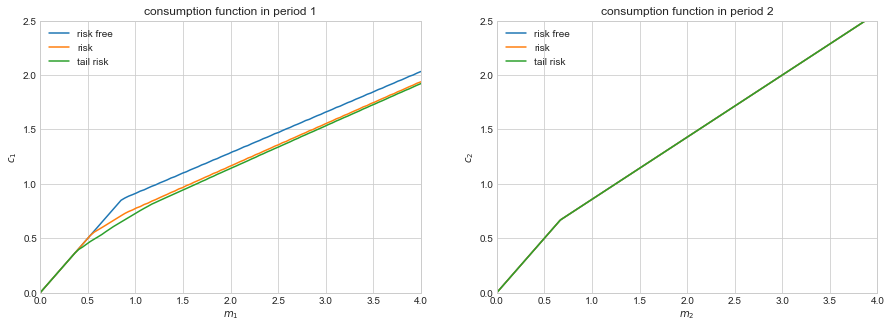

In [17]:
# solve for risk scenarios
m1_vec_r,c1_vec_r,m2_vec_r,c2_vec_r = modelproject.solve_risk(rho,beta,r,Delta,nu,kappa,modelproject.v1_risk)

m1_vec_tr,c1_vec_tr,m2_vec_tr,c2_vec_tr = modelproject.solve_risk(rho,beta,r,Delta,nu,kappa,modelproject.v1_tailrisk)

# plot all scenarios
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
ax.plot(m1_vec,c1_vec,label='risk free')
ax.plot(m1_vec_r,c1_vec_r,label='risk')
ax.plot(m1_vec_tr,c1_vec_tr,label='tail risk')

ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5])

ax = fig.add_subplot(1,2,2)
ax.plot(m2_vec,c2_vec,label='risk free')
ax.plot(m2_vec_r,c2_vec_r,label='risk')
ax.plot(m2_vec_tr,c2_vec_tr,label='tail risk')

ax.legend(loc='upper left')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

It is clear that uncertainty around future livelihood leads to precautionary saving. Also, because agents optimize for given levels of realized income in period 2, the consumption functions will be the same across risk scenarios. The precautionary savings scales with the coefficient of relative risk aversion.

# Simulation and Scenario Comparison

## Simulation

To simulate the model for a large number of consumers, we make a draw of 10 000 values of $m_1$ from a normal distribution. Then, for all three scenarios, we use interpolation methods to match the cash on hand level with the correct level of consumption.

In [23]:
# initial draw of cash on hand
seed = np.random.seed(2020)
simN = 10000
sim_m1 = np.fmax(np.random.normal(1,0.1,size=simN),0) # "randomly" chosen distribution

In [24]:
# a. simulate and plot for v1
m1_vec,c1_vec,m2_vec,c2_vec = solve(rho,beta,r,nu,kappa,v1)
c1_interp = interpolate.RegularGridInterpolator([m1_vec], c1_vec,
                                                bounds_error=False,fill_value=None)
c2_interp = interpolate.RegularGridInterpolator([m2_vec], c2_vec,
                                                bounds_error=False,fill_value=None)
# b. period 1
sim_c1 = c1_interp(sim_m1)
sim_a1 = sim_m1-sim_c1

# c. transition to period 2 with random draw
#sim_m2 = (1+r)*sim_a1+np.random.choice([0.5,1.5],p=[0.5,0.5],size=simN)

# d. period 2
sim_c2 = c2_interp(sim_m2)

In [25]:
# a. simulate and plot for v1_risk
m1_vec_r,c1_vec_r,m2_vec_r,c2_vec_r = modelproject.solve_risk(rho,beta,r,Delta,nu,kappa,modelproject.v1_risk)
c1_interp_r = interpolate.RegularGridInterpolator([m1_vec_r], c1_vec_r,
                                                bounds_error=False,fill_value=None)
c2_interp_r = interpolate.RegularGridInterpolator([m2_vec_r], c2_vec_r,
                                                bounds_error=False,fill_value=None)
# b. period 1
sim_c1_r = c1_interp_r(sim_m1)
sim_a1_r = sim_m1-sim_c1_r

# c. transition to period 2 with random draw
#sim_m2_r = (1+r)*sim_a1_r+np.random.choice([0.5,1.5],p=[0.5,0.5],size=simN)

# d. period 2
sim_c2_r = c2_interp_r(sim_m2_r)

In [26]:
# a. simulate and plot for v1_tailrisk
m1_vec_tr,c1_vec_tr,m2_vec_tr,c2_vec_tr = modelproject.solve_risk(rho,beta,r,Delta,nu,kappa,modelproject.v1_tailrisk)
c1_interp_tr = interpolate.RegularGridInterpolator([m1_vec_tr], c1_vec_tr,
                                                bounds_error=False,fill_value=None)
c2_interp_tr = interpolate.RegularGridInterpolator([m2_vec_tr], c2_vec_tr,
                                                bounds_error=False,fill_value=None)
# b. period 1
sim_c1_tr = c1_interp_tr(sim_m1)
sim_a1_tr = sim_m1-sim_c1_tr

# c. transition to period 2 with random draw
#sim_m2_tr = (1+r)*sim_a1_tr+np.random.choice([(1-np.sqrt(0.5)),0.5,1.5,(1+np.sqrt(0.5))],p=[0.1,0.4,0.4,0.1],size=simN)

# d. period 2
sim_c2_tr = c2_interp_tr(sim_m2_tr)

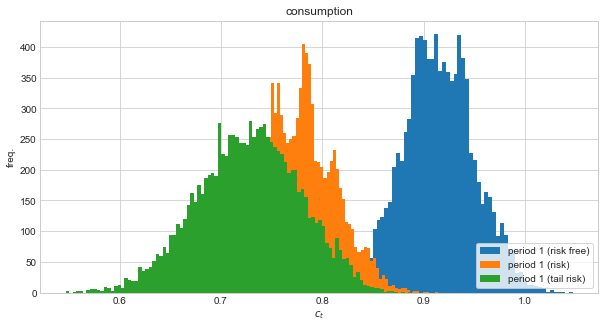

In [27]:
# plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

ax.hist(sim_c1,bins=100,label=f'period 1 (risk free)')
ax.hist(sim_c1_r,bins=100,label=f'period 1 (risk)')
ax.hist(sim_c1_tr,bins=100,label=f'period 1 (tail risk)')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_t$')
ax.set_ylabel('freq.')
ax.set_title('consumption'); 

As is evident from the figure, the precautionary savings effect carries over from the representative consumer to the heterogeneous simulation.

# Conclusion
In this project, we have applied various model analysis methods to a gradually expanding two period model of consumer behavior. initially, we performed analytical and numerical optimization of a simplified, risk free model using `sympy` and the **bisect** method. Next, we expanded the model; first with second period income and second with two types of income risk. Finally, we performed a simulation introducing heterogeneity in the initial endowment of cash on hand. 

## Disclaimer and call for creative (and feasible) ideas

We are aware that our project follows material from the lectures and exercise classes quite closely. When working on the assignment, we both discussed and tried implementing several model extensions (example given more sophisticated income shock distributions, introducing an inheritance tax etc.). However, our ideas proved either to bequite hard to implement given our limited programming knowledge, or to yield very uninteresting results. **Therefore, we would be very grateful for any suggestion on how to extend the model in an interesting and feasible way.**